In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt


# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

        # Indicators for the plotting show
        bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        bt.indicators.WeightedMovingAverage(self.datas[0], period=25,
                                            subplot=True)
        bt.indicators.StochasticSlow(self.datas[0])
        bt.indicators.MACDHisto(self.datas[0])
        rsi = bt.indicators.RSI(self.datas[0])
        bt.indicators.SmoothedMovingAverage(rsi, period=10)
        bt.indicators.ATR(self.datas[0], plot=False)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [2]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(TestStrategy)

# Datas are in a subfolder of the samples. Need to find where the script is
# because it could have been called from anywhere
# modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
# datapath = os.path.join(modpath, '../../datas/orcl-1995-2014.txt')
datapath = '/Users/jonathanl/Workspace/quant-workspace/backtrader/datas/orcl-1995-2014.txt'

# Create a Data Feed
data = bt.feeds.YahooFinanceCSVData(
    dataname=datapath,
    # Do not pass values before this date
    fromdate=datetime.datetime(2000, 1, 1),
    # Do not pass values before this date
    todate=datetime.datetime(2000, 12, 31),
    # Do not pass values after this date
    reverse=False)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000.0)

# Add a FixedSize sizer according to the stake
cerebro.addsizer(bt.sizers.FixedSize, stake=10)

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())


Starting Portfolio Value: 1000.00
2000-02-18, Close, 26.05
2000-02-22, Close, 26.38
2000-02-22, BUY CREATE, 26.38
2000-02-23, BUY EXECUTED, Price: 26.77, Cost: 267.70, Comm 0.00
2000-02-23, Close, 28.05
2000-02-24, Close, 27.55
2000-02-25, Close, 31.41
2000-02-28, Close, 30.52
2000-02-29, Close, 33.02
2000-03-01, Close, 31.80
2000-03-02, Close, 30.47
2000-03-03, Close, 33.36
2000-03-06, Close, 33.69
2000-03-07, Close, 33.33
2000-03-08, Close, 36.97
2000-03-09, Close, 37.36
2000-03-10, Close, 36.30
2000-03-13, Close, 35.02
2000-03-14, Close, 34.25
2000-03-15, Close, 34.97
2000-03-16, Close, 36.44
2000-03-17, Close, 35.50
2000-03-20, Close, 34.75
2000-03-21, Close, 35.89
2000-03-22, Close, 37.39
2000-03-23, Close, 38.64
2000-03-24, Close, 38.69
2000-03-27, Close, 39.33
2000-03-28, Close, 38.50
2000-03-29, Close, 36.69
2000-03-30, Close, 34.88
2000-03-30, SELL CREATE, 34.88
2000-03-31, SELL EXECUTED, Price: 35.66, Cost: 267.70, Comm 0.00
2000-03-31, OPERATION PROFIT, GROSS 88.90, NET 88.9

<IPython.core.display.Javascript object>


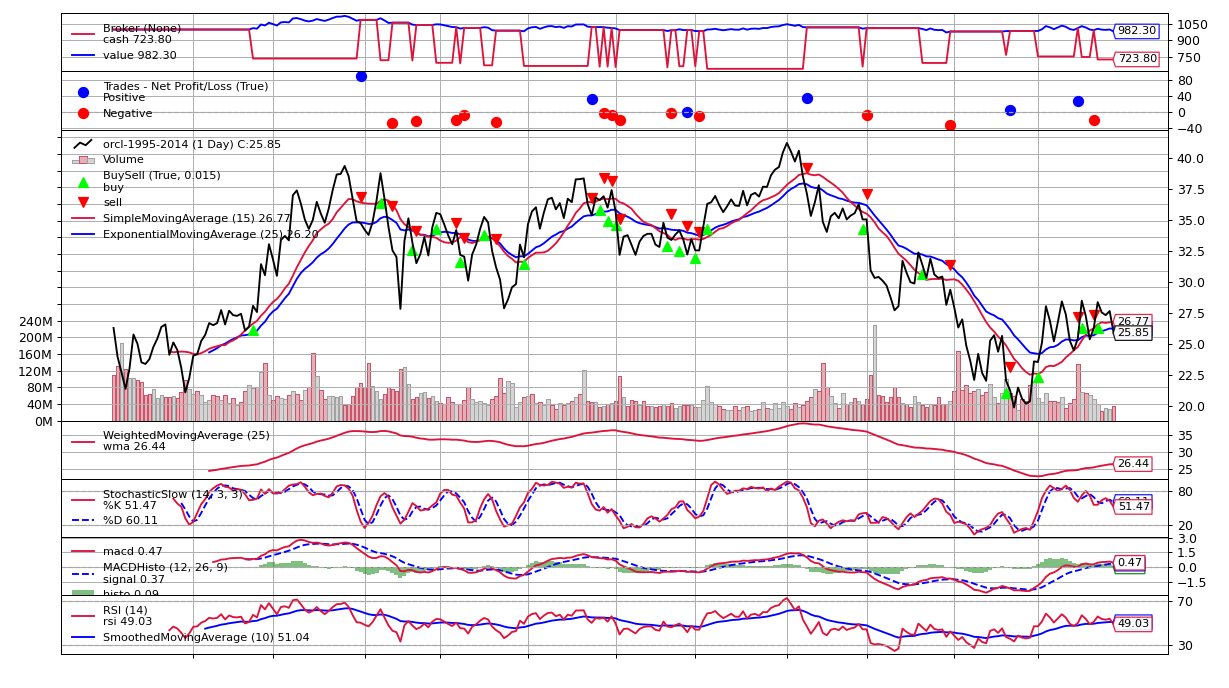

[[<Figure size 640x480 with 8 Axes>]]

In [3]:
# Plot the result
cerebro.plot()